In [3]:
import sys
sys.path.append("/media/HDD_2TB/marc/Video_Description/egocentric-video-description")
sys.path.append("/media/HDD_2TB/marc/multimodal_keras_wrapper")

from viddesc_model import VideoDesc_Model
from data_engine.prepare_data import build_dataset
from config import load_parameters

from keras_wrapper.cnn_model import loadModel, saveModel, transferWeights
from keras_wrapper.dataset import loadDataset
from keras_wrapper.extra.evaluation import *
from keras_wrapper.extra.callbacks import EarlyStopping
from keras_wrapper.extra.read_write import dict2pkl

# Plot libraries
from matplotlib.patches import Rectangle
import matplotlib as mpl
mpl.use('Agg') # run matplotlib without X server (GUI)
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from PIL import Image as pilimage
from scipy import ndimage

Using Theano backend.
WARNING (theano.gof.cmodule): The same cache key is associated to different modules (/home/lifelogging/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/tmpAtiGFX and /home/lifelogging/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/tmpOYkRDC). This is not supposed to happen! You may need to manually delete your cache directory to fix this.
WARNING (theano.gof.cmodule): The same cache key is associated to different modules (/home/lifelogging/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/tmpYWnT5p and /home/lifelogging/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/tmpdwVh76). This is not supposed to happen! You may need to manually delete your cache directory to fix this.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [4]:
# Load basic dataset
params = load_parameters()
params['REBUILD_DATASET'] = False
dataset = build_dataset(params)
params['OUTPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len[params['OUTPUTS_IDS_DATASET'][0]]

#params['RELOAD'] = 2
#params['STORE_PATH'] = 'trained_models/EDUB-SegDesc_features_ArcticVideoCaptionWithInit_txtemb_420_imgemb__lstmenc_600_lstm_484_deepout_maxout_Adam'

In [3]:
# Load initial model
model = loadModel('/media/HDD_2TB/marc/Video_Description/egocentric-video-description/'+params['STORE_PATH'], 
                      params['RELOAD'])

/home/lifelogging/code/keras_marc/keras/layers/core.py:656: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 301)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [3]:
scratch_video_model = VideoDesc_Model(params,
                                      type=params['MODEL_TYPE'],
                                      verbose=params['VERBOSE'],
                                      model_name=params['MODEL_NAME'],
                                      vocabularies=dataset.vocabulary,
                                      store_path=params['STORE_PATH'])

-----------------------------------------------------------------------------------
		VideoDesc_Model instance
-----------------------------------------------------------------------------------
_model_type: TemporallyLinkedVideoDescriptionAtt
name: EDUB-SegDesc_features-linked_TemporallyLinkedVideoDescriptionAtt_txtemb_301_imgemb__lstmenc_717_lstm_484_additional_output_mode_sum_deepout__Adam_lr_0.001_decay_1-0.95test
model_path: trained_models/EDUB-SegDesc_features-linked_TemporallyLinkedVideoDescriptionAtt_txtemb_301_imgemb__lstmenc_717_lstm_484_additional_output_mode_sum_deepout__Adam_lr_0.001_decay_1-0.95test/
verbose: 1

MODEL params:
{'SAMPLE_ON_SETS': ['train', 'val'], 'MAX_OUTPUT_TEXT_LEN': 30, 'SAMPLING_SAVE_MODE': 'list', 'TRG_LAN': 'en', 'SAMPLING': 'max_likelihood', 'SAMPLE_EACH_UPDATES': 50, 'BIDIRECTIONAL_PREV_SENT_ENCODER': True, 'CLIP_C': 10.0, 'TRG_PRETRAINED_VECTORS_TRAINABLE': True, 'USE_PRELU': False, 'ENCODER_HIDDEN_SIZE': 717, 'REBUILD_DATASET': False, 'METRICS': 

In [3]:
    ########### Build model
    if params['RELOAD'] == 0 or params['LOAD_WEIGHTS_ONLY']: # build new model
        video_model = VideoDesc_Model(params,
                                      type=params['MODEL_TYPE'],
                                      verbose=params['VERBOSE'],
                                      model_name=params['MODEL_NAME'],
                                      vocabularies=dataset.vocabulary,
                                      store_path=params['STORE_PATH'])
        dict2pkl(params, params['STORE_PATH'] + '/config')

        # Define the inputs and outputs mapping from our Dataset instance to our model
        inputMapping = dict()
        for i, id_in in enumerate(params['INPUTS_IDS_DATASET']):
            if len(video_model.ids_inputs) > i:
                pos_source = dataset.ids_inputs.index(id_in)
                id_dest = video_model.ids_inputs[i]
                inputMapping[id_dest] = pos_source
        video_model.setInputsMapping(inputMapping)
            
        outputMapping = dict()
        for i, id_out in enumerate(params['OUTPUTS_IDS_DATASET']):
            if len(video_model.ids_outputs) > i:
                pos_target = dataset.ids_outputs.index(id_out)
                id_dest = video_model.ids_outputs[i]
                outputMapping[id_dest] = pos_target
        video_model.setOutputsMapping(outputMapping)

        # Only load weights from pre-trained model
        if params['LOAD_WEIGHTS_ONLY'] and params['RELOAD'] > 0:
            for i in range(0, len(params['RELOAD'])):
                old_model = loadModel(params['PRE_TRAINED_MODEL_STORE_PATHS'][i], params['RELOAD'][i])
                video_model = transferWeights(old_model, video_model, params['LAYERS_MAPPING'][i])
            video_model.setOptimizer()
            params['RELOAD'] = 0

    else: # resume from previously trained model
        video_model = loadModel(params['PRE_TRAINED_MODEL_STORE_PATHS'], params['RELOAD'])
        video_model.setOptimizer()

        if video_model.model_path != params['STORE_PATH']:
            video_model.setName(params['MODEL_NAME'], models_path=params['STORE_PATH'], clear_dirs=False)
    ###########

-----------------------------------------------------------------------------------
		VideoDesc_Model instance
-----------------------------------------------------------------------------------
_model_type: TemporallyLinkedVideoDescriptionAtt
name: EDUB-SegDesc_features-linked_TemporallyLinkedVideoDescriptionAtt_txtemb_301_imgemb__lstmenc_717_lstm_484_additional_output_mode_sum_deepout__Adam_lr_0.001_decay_1-0.95test
model_path: trained_models/EDUB-SegDesc_features-linked_TemporallyLinkedVideoDescriptionAtt_txtemb_301_imgemb__lstmenc_717_lstm_484_additional_output_mode_sum_deepout__Adam_lr_0.001_decay_1-0.95test/
verbose: 1

MODEL params:
{'SAMPLE_ON_SETS': ['train', 'val'], 'MAX_OUTPUT_TEXT_LEN': 30, 'SAMPLING_SAVE_MODE': 'list', 'TRG_LAN': 'en', 'SAMPLING': 'max_likelihood', 'SAMPLE_EACH_UPDATES': 50, 'BIDIRECTIONAL_PREV_SENT_ENCODER': True, 'CLIP_C': 10.0, 'TRG_PRETRAINED_VECTORS_TRAINABLE': True, 'USE_PRELU': False, 'ENCODER_HIDDEN_SIZE': 717, 'REBUILD_DATASET': False, 'METRICS': 

/home/lifelogging/code/keras_marc/keras/layers/core.py:656: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 301)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


{u'activation_1': [<keras.layers.core.Activation object at 0x7f94cd2a7a50>, 17], u'initial_memory': [<keras.layers.core.Dense object at 0x7f94c8e50ad0>, 7], u'logit_lstm': [<keras.layers.wrappers.TimeDistributed object at 0x7f94c8cd30d0>, 14], u'target_word_embedding': [<keras.layers.embeddings.Embedding object at 0x7f94c8e96110>, 8], u'lambda_1': [<keras.layers.core.Lambda object at 0x7f94cd2a7a90>, 15], u'attlstmcond_1': [<keras.layers.recurrent.AttLSTMCond object at 0x7f94c8f1c6d0>, 11], u'description': [<keras.layers.wrappers.TimeDistributed object at 0x7f94c8cd3150>, 19], u'lambda_mean': [<keras.layers.core.Lambda object at 0x7f94c8df5c10>, 3], u'additional_input': [<keras.engine.topology.Merge object at 0x7f94cd2a7110>, 16], u'dropout_1': [<keras.layers.core.Dropout object at 0x7f94c8df5a10>, 4], u'dropout_3': [<keras.layers.core.Dropout object at 0x7f94c8efe110>, 10], u'dropout_2': [<keras.layers.core.Dropout object at 0x7f94c8e6ac90>, 9], u'video': [<keras.engine.topology.Input

In [5]:
old_model = loadModel(params['PRE_TRAINED_MODEL_STORE_PATH'], params['RELOAD'])

/home/lifelogging/code/keras_marc/keras/layers/core.py:656: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 301)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [5]:
print old_model.model_next
print old_model.model_init

None
None


In [13]:
old_names = [layer.name for layer in old_model.model.layers]
new_names = [layer.name for layer in video_model.model.layers]

In [14]:
print old_names
print
print new_names

[u'video', u'bidirectional_encoder', u'merge_1', u'lambda_mean', u'dropout_1', u'state_below', u'initial_state', u'initial_memory', u'target_word_embedding', u'dropout_2', u'dropout_3', u'attlstmcond_1', u'dropout_4', u'logit_ctx', u'logit_lstm', u'lambda_1', u'additional_input', u'activation_1', u'dropout_5', u'description']

['video', 'bidirectional_encoder_LSTM', 'merge_2', 'input_video_gaussian_noise', 'input_video_batch_normalization', 'prev_description', 'target_word_embedding', 'state_below', 'lambda_mean', 'encoder_prev_descLSTM', 'initial_state', 'initial_memory', 'target_word_embedding_gaussian_noise', 'prev_desc_enc_gaussian_noise', 'initial_state_gaussian_noise', 'initial_memory_gaussian_noise', 'target_word_embedding_batch_normalization', 'prev_desc_enc_batch_normalization', 'initial_state_batch_normalization', 'initial_memory_batch_normalization', 'decoder_AttLSTMCond2Inputs', 'proj_h0_gaussian_noise', 'proj_h0_batch_normalization', 'logit_ctx', 'logit_prev', 'logit_lstm'

In [7]:
old_layer_dict = dict([(layer.name, layer) for layer in old_model.model.layers])
new_layer_dict = dict([(layer.name, layer) for layer in video_model.model.layers])

In [16]:
old_weights = old_layer_dict['bidirectional_encoder'].get_weights()
for w in old_weights:
    print w.shape
print
new_weights = new_layer_dict['bidirectional_encoder_LSTM'].get_weights()
for w in new_weights:
    print w.shape

(1024, 2868)
(717, 2868)
(2868,)
(1024, 2868)
(717, 2868)
(2868,)

(1024, 2868)
(717, 2868)
(2868,)
(1024, 2868)
(717, 2868)
(2868,)


In [17]:
old_weights = old_layer_dict['initial_state'].get_weights()
for w in old_weights:
    print w.shape
print
new_weights = new_layer_dict['initial_state'].get_weights()
for w in new_weights:
    print w.shape

(2458, 484)
(484,)

(2458, 484)
(484,)


In [18]:
old_weights = old_layer_dict['target_word_embedding'].get_weights()
for w in old_weights:
    print w.shape
print
new_weights = new_layer_dict['target_word_embedding'].get_weights()
for w in new_weights:
    print w.shape

(13578, 301)

(832, 301)


In [19]:
old_weights = old_layer_dict['attlstmcond_1'].get_weights()
for w in old_weights:
    print w.shape
print
new_weights = new_layer_dict['decoder_AttLSTMCond2Inputs'].get_weights()
for w in new_weights:
    print w.shape

(2458,)
(484, 2458)
(2458, 2458)
(2458,)
(26,)
(301, 1936)
(2458, 1936)
(484, 1936)
(1936,)

(2458,)
(484, 2458)
(2458, 2458)
(2458,)
()
(2458, 1936)
(484, 1936)
(484, 1936)
(301, 1936)
(1936,)
(484,)
(484, 484)
(484, 484)
(484,)
()


In [20]:
old_weights = old_layer_dict['logit_ctx'].get_weights()
for w in old_weights:
    print w.shape
print
new_weights = new_layer_dict['logit_ctx'].get_weights()
for w in new_weights:
    print w.shape

(2458, 301)
(301,)

(2458, 301)
(301,)


In [21]:
old_weights = old_layer_dict['logit_lstm'].get_weights()
for w in old_weights:
    print w.shape
print
new_weights = new_layer_dict['logit_lstm'].get_weights()
for w in new_weights:
    print w.shape

(484, 301)
(301,)

(484, 301)
(301,)


In [23]:
old_weights = old_layer_dict['description'].get_weights()
for w in old_weights:
    print w.shape
print
new_weights = new_layer_dict['description'].get_weights()
for w in new_weights:
    print w.shape

(301, 13578)
(13578,)

(150, 832)
(832,)


In [4]:
new_layer_dict = dict([(layer.name, layer) for layer in video_model.model.layers])
next_layer_dict = dict([(layer.name, layer) for layer in video_model.model_next.layers])
init_layer_dict = dict([(layer.name, layer) for layer in video_model.model_init.layers])
scratch_layer_dict = dict([(layer.name, layer) for layer in scratch_video_model.model.layers])

NameError: name 'scratch_video_model' is not defined

In [5]:
#scratch_weights = scratch_layer_dict['description'].get_weights()
#for w in scratch_weights:
#    print w.shape
#print scratch_weights[0][:10,0]

new_weights = new_layer_dict['description'].get_weights()
for w in new_weights:
    print w.shape
print new_weights[0][:10,0]

next_weights = next_layer_dict['description'].get_weights()
for w in next_weights:
    print w.shape
print next_weights[0][:10,0]

init_weights = init_layer_dict['description'].get_weights()
for w in init_weights:
    print w.shape
print init_weights[0][:10,0]

(301, 15000)
(15000,)
[ 0.36372203  0.09116837 -0.42612514 -0.44709146  0.1938743   0.08794355
  0.87447399 -0.40271607  0.26959434 -0.24780366]
(301, 15000)
(15000,)
[ 0.36372203  0.09116837 -0.42612514 -0.44709146  0.1938743   0.08794355
  0.87447399 -0.40271607  0.26959434 -0.24780366]
(301, 15000)
(15000,)
[ 0.36372203  0.09116837 -0.42612514 -0.44709146  0.1938743   0.08794355
  0.87447399 -0.40271607  0.26959434 -0.24780366]


In [5]:
new_weights = new_layer_dict['description'].get_weights()
for w in new_weights:
    print w.shape
print new_weights[0][:10,0]

(301, 15000)
(15000,)
[ 0.36372203  0.09116837 -0.42612514 -0.44709146  0.1938743   0.08794355
  0.87447399 -0.40271607  0.26959434 -0.24780366]


In [6]:
#scratch_weights = scratch_layer_dict['prev_desc_emb_bidirectional_encoder_LSTM'].get_weights()
#for w in scratch_weights:
#    print w.shape
#print scratch_weights[0][:10,0]

new_weights = new_layer_dict['prev_desc_emb_bidirectional_encoder_LSTM'].get_weights()
for w in new_weights:
    print w.shape
print new_weights[0][:10,0]

#next_weights = next_layer_dict['prev_desc_emb_bidirectional_encoder_LSTM'].get_weights()
#for w in next_weights:
#    print w.shape
#print next_weights[0][:10,0]

init_weights = init_layer_dict['prev_desc_emb_bidirectional_encoder_LSTM'].get_weights()
for w in init_weights:
    print w.shape
print init_weights[0][:10,0]

(301, 2868)
(717, 2868)
(2868,)
(301, 2868)
(717, 2868)
(2868,)
[-0.00917163 -0.00153842  0.0106329  -0.00535513 -0.00266077  0.00394826
  0.00377789  0.00017624  0.0068661  -0.00624429]
(301, 2868)
(717, 2868)
(2868,)
(301, 2868)
(717, 2868)
(2868,)
[-0.00917163 -0.00153842  0.0106329  -0.00535513 -0.00266077  0.00394826
  0.00377789  0.00017624  0.0068661  -0.00624429]


In [6]:
new_weights = new_layer_dict['prev_desc_emb_bidirectional_encoder_LSTM'].get_weights()
for w in new_weights:
    print w.shape
print new_weights[0][:10,0]

(301, 2868)
(717, 2868)
(2868,)
(301, 2868)
(717, 2868)
(2868,)
[-0.00917163 -0.00153842  0.0106329  -0.00535513 -0.00266077  0.00394826
  0.00377789  0.00017624  0.0068661  -0.00624429]


In [5]:
#scratch_weights = scratch_layer_dict['description'].get_weights()
#for w in scratch_weights:
#    print w.shape
#print scratch_weights[0][:10,0]

new_weights = new_layer_dict['decoder_AttLSTMCond2Inputs'].get_weights()
for w in new_weights:
    print w.shape
print
print new_weights[1].shape
print new_weights[1][:10,0]

next_weights = next_layer_dict['decoder_AttLSTMCond2Inputs'].get_weights()
for w in next_weights:
    print w.shape
print next_weights[1][:10,0]

init_weights = init_layer_dict['decoder_AttLSTMCond2Inputs'].get_weights()
for w in init_weights:
    print w.shape
print init_weights[1][:10,0]

(2458,)
(484, 2458)
(2458, 2458)
(2458,)
()
(2458, 1936)
(1434, 1936)
(484, 1936)
(301, 1936)
(1936,)
(1434,)
(484, 1434)
(1434, 1434)
(1434,)
()

(484, 2458)
[  5.15654171e-03   5.91200450e-03   7.17863441e-03   1.43885473e-03
   7.17661018e-03   7.18622142e-03   7.18453294e-03  -2.62083275e-20
   1.75250703e-18  -3.60433587e-05]
(2458,)
(484, 2458)
(2458, 2458)
(2458,)
()
(2458, 1936)
(1434, 1936)
(484, 1936)
(301, 1936)
(1936,)
(1434,)
(484, 1434)
(1434, 1434)
(1434,)
()
[  5.15654171e-03   5.91200450e-03   7.17863441e-03   1.43885473e-03
   7.17661018e-03   7.18622142e-03   7.18453294e-03  -2.62083275e-20
   1.75250703e-18  -3.60433587e-05]
(2458,)
(484, 2458)
(2458, 2458)
(2458,)
()
(2458, 1936)
(1434, 1936)
(484, 1936)
(301, 1936)
(1936,)
(1434,)
(484, 1434)
(1434, 1434)
(1434,)
()
[  5.15654171e-03   5.91200450e-03   7.17863441e-03   1.43885473e-03
   7.17661018e-03   7.18622142e-03   7.18453294e-03  -2.62083275e-20
   1.75250703e-18  -3.60433587e-05]


In [7]:
abivirnet_model = loadModel(params['PRE_TRAINED_MODEL_STORE_PATHS'][0], 2)

In [8]:
abivirnet_layer_dict = dict([(layer.name, layer) for layer in abivirnet_model.model.layers])

In [9]:
new_weights = abivirnet_layer_dict['attlstmcond_1'].get_weights()
for w in new_weights:
    print w.shape
print
print new_weights[1].shape
print new_weights[1][:10,0]

(2458,)
(484, 2458)
(2458, 2458)
(2458,)
(26,)
(301, 1936)
(2458, 1936)
(484, 1936)
(1936,)

(484, 2458)
[  5.15654171e-03   5.91200450e-03   7.17863441e-03   1.43885473e-03
   7.17661018e-03   7.18622142e-03   7.18453294e-03  -2.62083275e-20
   1.75250703e-18  -3.60433587e-05]


In [30]:
w = abivirnet_layer_dict['attlstmcond_1'].get_weights()
new_shapes = [w_.shape for w_ in w]
for s in new_shapes:
    print s

(2458,)
(484, 2458)
(2458, 2458)
(2458,)
(26,)
(301, 1936)
(2458, 1936)
(484, 1936)
(1936,)


In [8]:
words_model = loadModel(params['PRE_TRAINED_MODEL_STORE_PATHS'][1], 0)

In [9]:
words_layer_dict = dict([(layer.name, layer) for layer in words_model.model.layers])

In [10]:
new_weights = words_layer_dict['bidirectional_encoder_LSTM'].get_weights()
for w in new_weights:
    print w.shape
print new_weights[0][:10,0]

(301, 2868)
(717, 2868)
(2868,)
(301, 2868)
(717, 2868)
(2868,)
[-0.00917163 -0.00153842  0.0106329  -0.00535513 -0.00266077  0.00394826
  0.00377789  0.00017624  0.0068661  -0.00624429]


In [13]:
scratch_weights = scratch_layer_dict['target_word_embedding'].get_weights()
for w in scratch_weights:
    print w.shape
print scratch_weights[0][:10,0]

new_weights = new_layer_dict['target_word_embedding'].get_weights()
for w in new_weights:
    print w.shape
print new_weights[0][:10,0]

next_weights = next_layer_dict['target_word_embedding'].get_weights()
for w in next_weights:
    print w.shape
print next_weights[0][:10,0]

init_weights = init_layer_dict['target_word_embedding'].get_weights()
for w in init_weights:
    print w.shape
print init_weights[0][:10,0]

(15000, 301)
[ 0.00896137  0.0058687   0.02104132  0.01981896  0.03314291 -0.00925888
 -0.01896602 -0.04003912  0.00936839 -0.02531725]
(15000, 301)
[ 0.03097132  0.03124981  0.02156269  0.03412048  0.00267495 -0.0386994
 -0.02263315 -0.03677199  0.02390226  0.0259914 ]
(15000, 301)
[ 0.03097132  0.03124981  0.02156269  0.03412048  0.00267495 -0.0386994
 -0.02263315 -0.03677199  0.02390226  0.0259914 ]
(15000, 301)
[ 0.03097132  0.03124981  0.02156269  0.03412048  0.00267495 -0.0386994
 -0.02263315 -0.03677199  0.02390226  0.0259914 ]


-----------------------------------------------------------------------------------
		VideoDesc_Model instance
-----------------------------------------------------------------------------------
_model_type: TemporallyLinkedVideoDescriptionAtt
name: EDUB-SegDesc_features-linked_TemporallyLinkedVideoDescriptionAtt_txtemb_301_imgemb__lstmenc_717_lstm_484_additional_output_mode_sum_deepout__Adam_lr_0.001_decay_1-0.95test
model_path: trained_models/EDUB-SegDesc_features-linked_TemporallyLinkedVideoDescriptionAtt_txtemb_301_imgemb__lstmenc_717_lstm_484_additional_output_mode_sum_deepout__Adam_lr_0.001_decay_1-0.95test/
verbose: 1

MODEL params:
{'SAMPLE_ON_SETS': ['train', 'val'], 'MAX_OUTPUT_TEXT_LEN': 30, 'SAMPLING_SAVE_MODE': 'list', 'TRG_LAN': 'en', 'SAMPLING': 'max_likelihood', 'SAMPLE_EACH_UPDATES': 50, 'BIDIRECTIONAL_PREV_SENT_ENCODER': True, 'CLIP_C': 10.0, 'TRG_PRETRAINED_VECTORS_TRAINABLE': True, 'USE_PRELU': False, 'ENCODER_HIDDEN_SIZE': 717, 'REBUILD_DATASET': False, 'METRICS': 

In [6]:
from keras_wrapper.cnn_model import transferWeights as tw

video_model = tw(old_model, video_model, params['LAYERS_MAPPING'])

In [11]:
print video_model.vocabularies.keys()
len(video_model.vocabularies['prev_description']['idx2words'].keys())

NameError: name 'video_model' is not defined

In [10]:
len(dataset.vocabulary['prev_description']['idx2words'].keys())

13578

In [4]:
dataset.vocabulary.keys()

['prev_description', 'state_below', 'description']

In [9]:
len(dataset.vocabulary['description']['idx2words'].keys())

13578

In [3]:
dataset_pretrained = loadDataset(params['DATASET_STORE_PATH']+'Dataset_'+params['PRE_TRAINED_DATASET_NAME']+'.pkl')

In [8]:
print dataset.vocabulary_len
print dataset_pretrained.vocabulary_len

{'prev_description': 13578, 'state_below': 13578, 'description': 13578}
{'description': 13578}


In [7]:
dataset.vocabulary['description'] = copy.deepcopy(dataset_pretrained.vocabulary['description'])
dataset.vocabulary_len['description'] = copy.deepcopy(dataset_pretrained.vocabulary_len['description'])

dataset.vocabulary['prev_description'] = copy.deepcopy(dataset_pretrained.vocabulary['description'])
dataset.vocabulary_len['prev_description'] = copy.deepcopy(dataset_pretrained.vocabulary_len['description'])

dataset.vocabulary['state_below'] = copy.deepcopy(dataset_pretrained.vocabulary['description'])
dataset.vocabulary_len['state_below'] = copy.deepcopy(dataset_pretrained.vocabulary_len['description'])

In [3]:
for id_old, id_new in params['VOCABULARIES_MAPPING'].iteritems():
            print id_old
            print id_new
            print

description
prev_description



In [4]:
params['VOCABULARIES_MAPPING']

{'description': 'prev_description'}

## '-linked' dataset inspection

In [5]:
set_split = 'train'
[Xdeb, Ydeb] = dataset.getXY_FromIndices(set_split, range(1000,1050), debug=True)
[X, Y] = dataset.getXY_FromIndices(set_split, range(1000,1050),normalization=False, meanSubstraction=False, dataAugmentation=False)

[121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127]

Print some statistics:
889
225
0.25309336333


plotting event
['Images/Pedro1/20160805_040856_000.jpg', 'Images/Pedro1/20160805_040956_000.jpg', 'Images/Pedro1/20160805_041058_000.jpg', 'Images/Pedro1/20160805_041159_000.jpg', 'Images/Pedro1/20160805_041259_000.jpg', 'Images/Pedro1/20160805_041401_000.jpg', 'Images/Pedro1/20160805_041505_000.jpg', 'Images/Pedro1/20160805_041637_000.jpg', 'Images/Pedro1/20160805_041710_000.jpg', 'Images/Pedro1/20160805_041819_000.jpg']
121 : 121 [a man sold a ticket to me] --> i was on the street and entered in a car
121 : 121 [a man sold a ticket to me] --> i talked with some woman and stepped on a car
121 : 121 [a man sold a ticket to me] --> some women and i talked and stepped on a car

plotting event
[

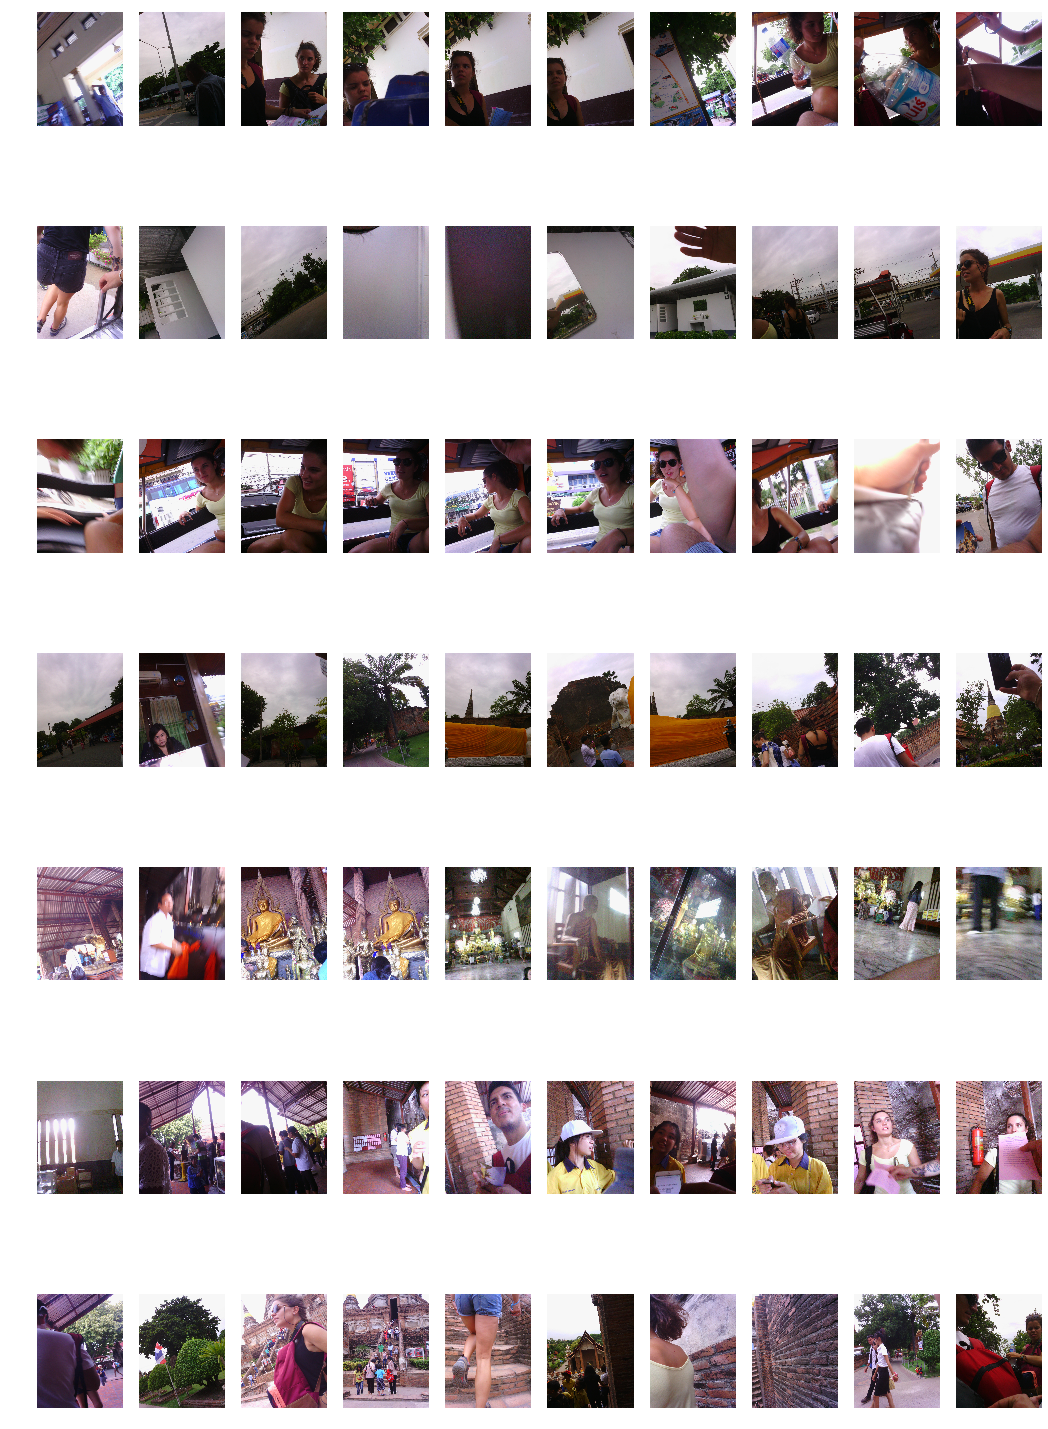

In [6]:
#selected_frames = dataset.getFramesPaths(Xdeb[0], params['INPUTS_IDS_DATASET'][0], 'train', 
#                                         params['NUM_FRAMES'], data_augmentation=False)
print Xdeb[0]
#print selected_frames


# Get list of images and list of counts
images_list = '/media/HDD_3TB/DATASETS/EDUB-SegDesc/Annotations/'+set_split+'_imgs_list.txt'
images_counts = '/media/HDD_3TB/DATASETS/EDUB-SegDesc/Annotations/'+set_split+'_imgs_counts.txt'
counts = []
imgs_list = []
with open(images_list, 'r') as fileim:
    for line in fileim:
        line = line.rstrip('\n')
        imgs_list.append(line)
with open(images_counts, 'r') as filect:
    for line in filect:
        line = line.rstrip('\n')
        counts.append(int(line))

print 
print 'Print some statistics:'
print len(counts)
num_small_segments = sum([1 if c<10 else 0 for c in counts])
print num_small_segments
print float(num_small_segments)/len(counts)
print
        
prev_im = -1
count_plotted = 1
random_sel = 10

f = plt.figure(1)
f.set_size_inches(18,30)

for im,sin,sout,l in zip(Xdeb[0],Xdeb[2],Ydeb[0], Xdeb[3]):
    if prev_im != im:
        # Plot some images
        if im == 0:
            ini_pos = 0
        else:
            ini_pos = sum(counts[:im])
        fin_pos = ini_pos + counts[im]
        current_imgs = imgs_list[ini_pos:fin_pos]
        # Pick random_sel images randomly from the event
        #random_images = sorted(np.random.choice(current_imgs, random_sel))
        # Pick them equidistantly
        random_images = [current_imgs[int(idim)] for idim in np.linspace(0,len(current_imgs)-1,random_sel)]
        # Plot images
        print
        print 'plotting event'
        print random_images
        for im_plot in random_images:
            
            im_plot = pilimage.open(dataset.path+im_plot)
            #im_plot = im.convert('RGB')
            im_plot = np.asarray(im_plot)

            ax = plt.subplot(8,random_sel,count_plotted)
            plt.imshow(im_plot)
            plt.axis('off')
            count_plotted += 1
        
    print im,':',sin,'['+str(l)+'] -->',sout
    prev_im = im

In [70]:
set_split = 'train'
[Xdeb, Ydeb] = dataset.getXY_FromIndices(set_split, range(2000,2050), debug=True)
[X, Y] = dataset.getXY_FromIndices(set_split, range(2000,2050),normalization=False, meanSubstraction=False, dataAugmentation=False)

[239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 241, 241, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244, 244, 244, 244, 244]

plotting event
['Images/Maya5/20160610_125520_000.jpg', 'Images/Maya5/20160610_130157_000.jpg', 'Images/Maya5/20160610_130853_000.jpg', 'Images/Maya5/20160610_131549_000.jpg', 'Images/Maya5/20160610_132258_000.jpg', 'Images/Maya5/20160610_132922_000.jpg', 'Images/Maya5/20160610_133618_000.jpg', 'Images/Maya5/20160610_134327_000.jpg', 'Images/Maya5/20160610_135023_000.jpg', 'Images/Maya5/20160610_135719_000.jpg']
239 : i read in a garden [238] --> i entered in classrooms full of people
239 : i read in a garden [238] --> i entered in classrooms and talked to different people
239 : i studied in a garden of a university [238] --> i walked between two classrooms
239 : i studied in a garden of a university [238] --> i entered in classrooms full

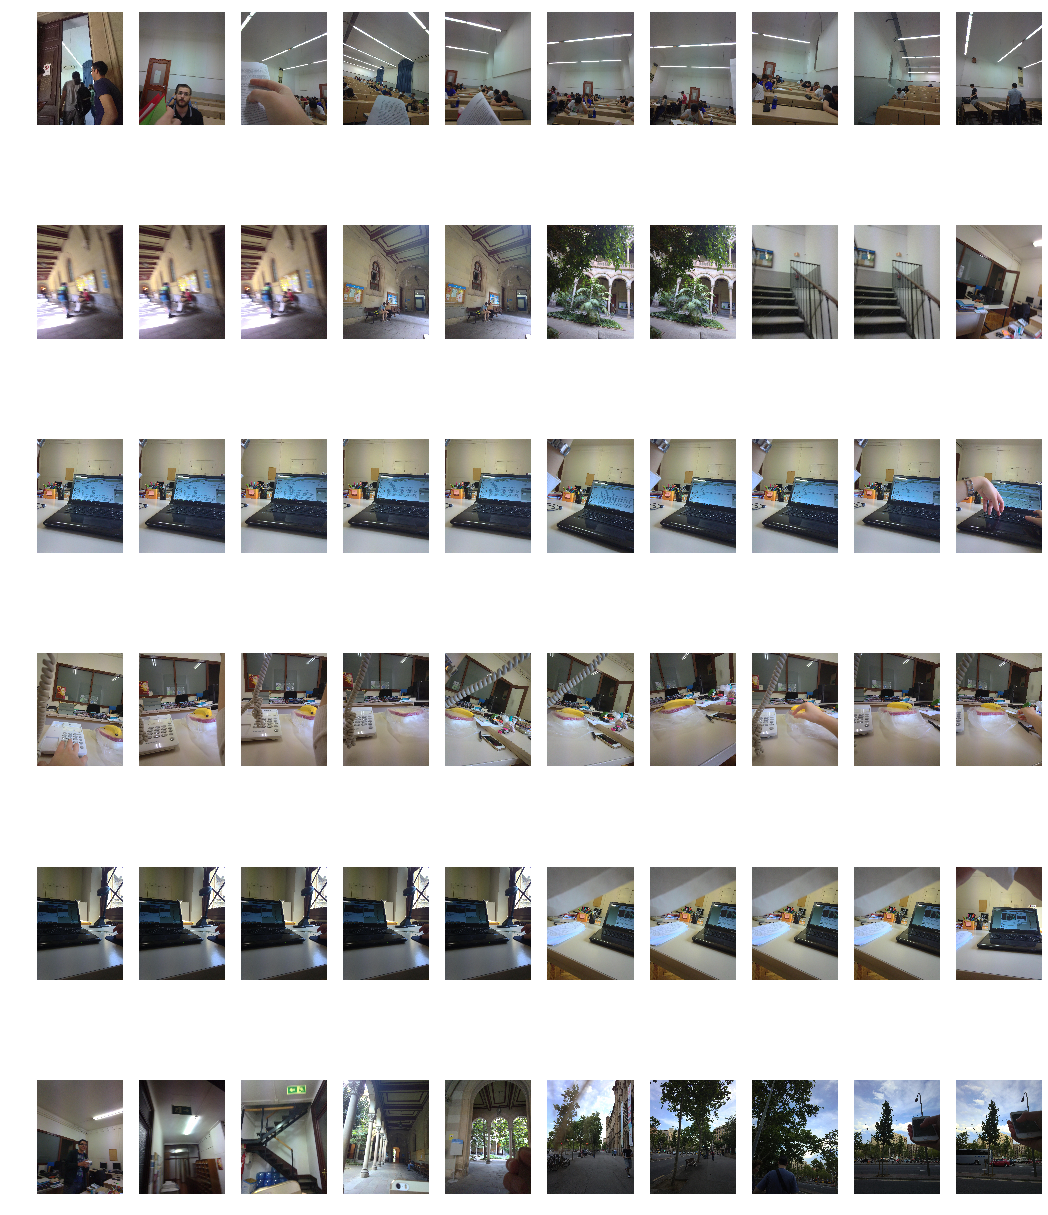

In [72]:
#selected_frames = dataset.getFramesPaths(Xdeb[0], params['INPUTS_IDS_DATASET'][0], 'train', 
#                                         params['NUM_FRAMES'], data_augmentation=False)
print Xdeb[0]
#print selected_frames


# Get list of images and list of counts
images_list = '/media/HDD_3TB/DATASETS/EDUB-SegDesc/Annotations/'+set_split+'_imgs_list.txt'
images_counts = '/media/HDD_3TB/DATASETS/EDUB-SegDesc/Annotations/'+set_split+'_imgs_counts.txt'
counts = []
imgs_list = []
with open(images_list, 'r') as fileim:
    for line in fileim:
        line = line.rstrip('\n')
        imgs_list.append(line)
with open(images_counts, 'r') as filect:
    for line in filect:
        line = line.rstrip('\n')
        counts.append(int(line))
        
prev_im = -1
count_plotted = 1
random_sel = 10

f = plt.figure(1)
f.set_size_inches(18,30)

for im,sin,sout,l in zip(Xdeb[0],Xdeb[2],Ydeb[0], Xdeb[3]):
    if prev_im != im:
        # Plot some images
        if im == 0:
            ini_pos = 0
        else:
            ini_pos = sum(counts[:im])
        fin_pos = ini_pos + counts[im]
        current_imgs = imgs_list[ini_pos:fin_pos]
        # Pick random_sel images randomly from the event
        #random_images = sorted(np.random.choice(current_imgs, random_sel))
        # Pick them equidistantly
        random_images = [current_imgs[int(idim)] for idim in np.linspace(0,len(current_imgs)-1,random_sel)]
        # Plot images
        print
        print 'plotting event'
        print random_images
        for im_plot in random_images:
            
            im_plot = pilimage.open(dataset.path+im_plot)
            #im_plot = im.convert('RGB')
            im_plot = np.asarray(im_plot)

            ax = plt.subplot(8,random_sel,count_plotted)
            plt.imshow(im_plot)
            plt.axis('off')
            count_plotted += 1
        
    print im,':',sin,'['+str(l)+'] -->',sout
    prev_im = im

In [3]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('train', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('train', range(50))

In [4]:
for im,sin,sout,l in zip(Xdeb[0],Xdeb[2],Ydeb[0], Xdeb[3]):
    print im,':',sin,'['+str(l)+'] -->',sout

0 :  [-1] --> i walked on the street
0 :  [-1] --> i walked in a park
0 :  [-1] --> i strolled in a garden
1 : i walked on the street [0] --> i entered in a building
1 : i walked on the street [0] --> i went insides
1 : i walked in a park [0] --> i entered in a building
1 : i walked in a park [0] --> i went insides
1 : i strolled in a garden [0] --> i entered in a building
1 : i strolled in a garden [0] --> i went insides
2 : i entered in a building [1] --> i walked on the street
2 : i entered in a building [1] --> i walked in the city
2 : i entered in a building [1] --> i walked in a park and on the street
2 : i went insides [1] --> i walked on the street
2 : i went insides [1] --> i walked in the city
2 : i went insides [1] --> i walked in a park and on the street
3 : i walked on the street [2] --> i entered in a room with computer
3 : i walked on the street [2] --> i went to a copy shop
3 : i walked on the street [2] --> i walked in a copy shop
3 : i walked in the city [2] --> i ent

In [72]:
for sin,sout,state_below,l in zip(X[2], Y[0][0], X[1], X[3]):
    sin = map(lambda x: dataset.vocabulary['description']['idx2words'][x], sin)
    sin = ' '.join(sin)
    sout_ = [np.argmax(w) for w in sout]
    sout = map(lambda x: dataset.vocabulary['description']['idx2words'][x], sout_)
    sout = ' '.join(sout)
    print l,':'
    print sin
    print '-->'
    print sout
    print '------'

-1 :
<unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i looked at the ceiling <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
-1 :
<unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i walked in the house <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
-1 :
<unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i walked in the house <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
0 :
i looked at the ceiling <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i walked on the street <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
0 :
i looked at the ceiling <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i walked down the street <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
0 :
i looked at the ceiling <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i looked at buildings and trees <pad> <pad

## '-linked-upperbound' dataset inspection

In [4]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('train', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('train', range(50))

In [5]:
for im,sin,sout in zip(Xdeb[0],Xdeb[2],Ydeb[0]):
    print im,':',sin,'-->',sout

0 : i looked at the ceiling --> i looked at the ceiling
0 : i looked at the ceiling --> i walked in the house
0 : i looked at the ceiling --> i walked in the house
0 : i walked in the house --> i looked at the ceiling
0 : i walked in the house --> i walked in the house
0 : i walked in the house --> i walked in the house
0 : i walked in the house --> i looked at the ceiling
0 : i walked in the house --> i walked in the house
0 : i walked in the house --> i walked in the house
1 : i walked on the street --> i walked on the street
1 : i walked on the street --> i walked down the street
1 : i walked on the street --> i looked at buildings and trees
1 : i walked down the street --> i walked on the street
1 : i walked down the street --> i walked down the street
1 : i walked down the street --> i looked at buildings and trees
1 : i looked at buildings and trees --> i walked on the street
1 : i looked at buildings and trees --> i walked down the street
1 : i looked at buildings and trees --> 

## '-linked-upperbound-copy' dataset inspection

In [5]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('val', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('val', range(50))

In [6]:
for im,sin,sout in zip(Xdeb[0],Xdeb[2],Ydeb[0]):
    print im,':',sin,'-->',sout

0 : error --> error
1 : i drove my car --> i drove my car
2 : i walked on the street --> i walked on the street
3 : i entered in the train station and waited for it --> i entered in the train station and waited for it
4 : i was inside a train --> i was inside a train
5 : i left the station --> i left the station
6 : i walked on the street and entered in a building --> i walked on the street and entered in a building
7 : i went to my office --> i went to my office
8 : i used my laptop --> i used my laptop
9 : i went ot the bathroom --> i went ot the bathroom
10 : i worked with my laptop --> i worked with my laptop
11 : i walked in a building --> i walked in a building
12 : i worked at a table with a laptop --> i worked at a table with a laptop
13 : i used my laptop and a computer --> i used my laptop and a computer
14 : i went to the bathroom --> i went to the bathroom
15 : i went to my office --> i went to my office
16 : i worked in a library --> i worked in a library
17 : i went to my

## '-linked-upperbound-prev' dataset inspection

In [5]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('val', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('val', range(50))

In [6]:
for im,sin,sout in zip(Xdeb[0],Xdeb[2],Ydeb[0]):
    print im,':',sin,'-->',sout

0 :  --> i was in a car with other people looking at a map
1 : i was in a car with other people looking at a map --> i entered in the reception
1 : i looked at a map and a notebook while travelling by car --> i entered in the reception
1 : i was sitting in a car with other people while reading a notebook and a map --> i entered in the reception
2 : i entered in the reception --> i was at the terrace of the hotel
2 : i entered in the hotel --> i was at the terrace of the hotel
2 : i was at a hotel --> i was at the terrace of the hotel
3 : i was at the terrace of the hotel --> i walked around the hotel
3 : i was talking with people at the terrace --> i walked around the hotel
3 : i looked at the map while being at the terrace of a hotel --> i walked around the hotel
4 : i walked around the hotel --> i looked at the surroundings
4 : i went to my hotel room --> i looked at the surroundings
4 : i was in a hotel --> i looked at the surroundings
5 : i looked at the surroundings --> i went to 

## '-linked-upperbound-nocopy' dataset inspection

In [3]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('val', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('val', range(50))

In [4]:
for im,sin,sout in zip(Xdeb[0],Xdeb[2],Ydeb[0]):
    print im,':',sin,'-->',sout

0 :  --> i was in a car with other people looking at a map
1 : i was in a car with other people looking at a map --> i entered in the reception
1 : i looked at a map and a notebook while travelling by car --> i entered in the reception
1 : i was sitting in a car with other people while reading a notebook and a map --> i entered in the reception
2 : i entered in the reception --> i was at the terrace of the hotel
2 : i entered in the hotel --> i was at the terrace of the hotel
2 : i was at a hotel --> i was at the terrace of the hotel
3 : i was at the terrace of the hotel --> i walked around the hotel
3 : i was talking with people at the terrace --> i walked around the hotel
3 : i looked at the map while being at the terrace of a hotel --> i walked around the hotel
4 : i walked around the hotel --> i looked at the surroundings
4 : i went to my hotel room --> i looked at the surroundings
4 : i was in a hotel --> i looked at the surroundings
5 : i looked at the surroundings --> i went to 

In [6]:
len(dataset.vocabulary['description']['idx2words'])

15000

## '-linked-upperbound-video' dataset inspection

In [3]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('val', range(10), debug=True)
[X, Y] = dataset.getXY_FromIndices('val', range(10))

In [16]:
paths = dataset.paths_frames['prev_description']['test']
counts = dataset.counts_frames['prev_description']['test']

In [17]:
print len(counts)
print len(paths)
print len(dataset.X_test['prev_description'])
print dataset.len_test


187
5224
187
187


## dataset data augmentation tests

In [5]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('train', range(10), debug=False, dataAugmentation=False)
[Xdeb_da, Ydeb_da] = dataset.getXY_FromIndices('train', range(10), debug=False, dataAugmentation=True)

In [6]:
Xdeb[0][0].shape

print Xdeb[0][3][:,:10]
print
print Xdeb_da[0][3][:,:10]

[[ 0.75592    1.9075     0.58342    0.85078    0.         0.42813    0.24454
   0.068608   0.         0.040536 ]
 [ 1.1501     2.9504     0.         1.0517     1.678      0.19195    0.10056
   0.014799   0.048234   4.0547   ]
 [ 0.39779    0.         0.2717     0.1937     0.75908    0.44541    0.4211
   0.0076662  0.         0.024766 ]
 [ 0.         0.         1.314      0.75633    0.43701    0.57059    0.59137
   0.         0.082287   0.028755 ]
 [ 0.         1.6471     0.         0.51928    0.24952    0.26292    0.84754
   0.035945   0.052117   0.11951  ]
 [ 0.         1.7177     0.25368    3.0476     0.         0.059234   0.2563
   0.0074443  0.         0.82942  ]
 [ 0.05447    0.4656     0.090273   2.1388     0.         0.63697
   0.0065102  0.54313    0.         0.32508  ]
 [ 0.044078   0.         0.040765   0.         0.025378   0.16243    2.2037
   0.         0.14177    0.       ]
 [ 0.21755    0.         0.37068    0.090255   0.         0.0046793
   0.36733    0.         0.3149